#Install Dependencies


In [ ]:
!pip install -q tensorflow_addons
!pip install -q vit-keras
!pip install tensorflow_hub
!pip install -q kaggle
!pip install vit-keras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 38.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.5 MB/s eta 0:00:00


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
import tensorflow as tf
import zipfile
import os
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from transformers import ViTFeatureExtractor, ViTForImageClassification
from vit_keras import vit

#Handling Data

In [ ]:
!kaggle datasets download -d emmarex/plantdisease

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 99% 650M/658M [00:03<00:00, 216MB/s]
100% 658M/658M [00:06<00:00, 112MB/s]


In [ ]:
with zipfile.ZipFile("plantdisease.zip", 'r') as zip_ref:
    zip_ref.extractall("plantvillage")

os.listdir("plantvillage")

['plantvillage', 'PlantVillage']

Reducing Data size to avoid RAM crash

In [ ]:
import random
import shutil

# Paths
source_dir = "plantvillage/PlantVillage"  # Corrected source directory
target_dir = "PlantVillage_small"  # reduced dataset folder

# Create target directory
os.makedirs(target_dir, exist_ok=True)

# Max images per class
max_images_per_class = 200

# Loop over each class folder
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)

    # Skip if not a directory
    if not os.path.isdir(class_path):
        continue

    target_class_path = os.path.join(target_dir, class_name)
    os.makedirs(target_class_path, exist_ok=True)

    # Get image files only
    images = [f for f in os.listdir(class_path) if not f.startswith(".")]
    random.shuffle(images)

    # Copy limited images
    for img in images[:max_images_per_class]:
        shutil.copy(os.path.join(class_path, img), target_class_path)

    print(f"Copied {min(len(images), max_images_per_class)} images to {target_class_path}")

print("✅ Dataset reduction complete!")

Copied 200 images to PlantVillage_small/Tomato_Spider_mites_Two_spotted_spider_mite
Copied 200 images to PlantVillage_small/Tomato_healthy
Copied 200 images to PlantVillage_small/Potato___Late_blight
Copied 152 images to PlantVillage_small/Potato___healthy
Copied 200 images to PlantVillage_small/Pepper__bell___Bacterial_spot
Copied 200 images to PlantVillage_small/Tomato__Target_Spot
Copied 200 images to PlantVillage_small/Pepper__bell___healthy
Copied 200 images to PlantVillage_small/Tomato_Bacterial_spot
Copied 200 images to PlantVillage_small/Tomato__Tomato_mosaic_virus
Copied 200 images to PlantVillage_small/Tomato_Septoria_leaf_spot
Copied 200 images to PlantVillage_small/Tomato_Late_blight
Copied 200 images to PlantVillage_small/Tomato_Early_blight
Copied 200 images to PlantVillage_small/Potato___Early_blight
Copied 200 images to PlantVillage_small/Tomato__Tomato_YellowLeaf__Curl_Virus
Copied 200 images to PlantVillage_small/Tomato_Leaf_Mold
✅ Dataset reduction complete!


In [ ]:
target_dir

'PlantVillage_small'

#Efficientnet Preprocessing

In [ ]:
SEED = 42
IMG_SIZE = 224
BATCH_SIZE = 32
DATA_DIR = target_dir


In [ ]:
tf.random.set_seed(SEED)
np.random.seed(SEED)

train_ds= tf.keras.utils.image_dataset_from_directory(DATA_DIR,validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)
validation_ds= tf.keras.utils.image_dataset_from_directory(DATA_DIR,validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Found 2952 files belonging to 15 classes.
Using 2362 files for training.
Found 2952 files belonging to 15 classes.
Using 590 files for validation.


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
])

In [ ]:
preprocess_input_EFFNET = tf.keras.applications.efficientnet.preprocess_input

AUTOTUNE = tf.data.AUTOTUNE


In [ ]:
train_ds_EFFNET = (
    train_ds
    .map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTOTUNE)
    .map(lambda x, y: (preprocess_input_EFFNET(x), y), num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(1000)
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds_EFFNET = (
    validation_ds
    .map(lambda x, y: (preprocess_input_EFFNET(x), y), num_parallel_calls=AUTOTUNE)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


In [ ]:
class_names = tf.keras.utils.image_dataset_from_directory(DATA_DIR).class_names
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Found 2952 files belonging to 15 classes.
Number of classes: 15
Class names: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


#Efficientnet Modeling

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
base_model.trainable = False  # Freeze base layers initially

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model_effnet = tf.keras.Model(inputs, outputs)

In [ ]:
model_effnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history_effnet = model_effnet.fit(
    train_ds_EFFNET,
    validation_data=val_ds_EFFNET,
    epochs=10
)

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 79s 374ms/step - accuracy: 0.2675 - loss: 2.3691 - val_accuracy: 0.6729 - val_loss: 1.4333
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6948 - loss: 1.2881 - val_accuracy: 0.7508 - val_loss: 1.0665
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7705 - loss: 0.9405 - val_accuracy: 0.7678 - val_loss: 0.8698
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8086 - loss: 0.7616 - val_accuracy: 0.7746 - val_loss: 0.7937
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8529 - loss: 0.6448 - val_accuracy: 0.7644 - val_loss: 0.7451
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8564 - loss: 0.5704 - val_accuracy: 0.8085 - val_loss: 0.6725
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8818 - loss: 0.5004 - val_accuracy: 0.7983 - val_loss: 0.6452
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8983 - loss: 0.4555 - val_accuracy: 0.8000 -

In [ ]:
base_model.trainable = True
model_effnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
history_effnet_fine = model_effnet.fit(
    train_ds_EFFNET,
    validation_data=val_ds_EFFNET,
    epochs=5
)


Epoch 1/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 137s 843ms/step - accuracy: 0.4803 - loss: 1.6648 - val_accuracy: 0.7864 - val_loss: 0.6023
Epoch 2/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.6314 - loss: 1.2556 - val_accuracy: 0.7695 - val_loss: 0.7099
Epoch 3/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.7350 - loss: 0.9626 - val_accuracy: 0.7356 - val_loss: 0.7871
Epoch 4/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.7641 - loss: 0.8013 - val_accuracy: 0.7186 - val_loss: 0.8475
Epoch 5/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.8180 - loss: 0.6840 - val_accuracy: 0.7305 - val_loss: 0.8725


In [ ]:
# Fine-tuning done, now save model and history

model_effnet.save("efficientnet_finetuned_model.keras")

import pickle
with open('history_effnet_fine.pkl', 'wb') as f:
    pickle.dump(history_effnet_fine.history, f)


#Vision Transformer (VIT) Preprocessing

In [ ]:
IMG_SIZE_VIT = 128
BATCH_SIZE_VIT = 16

In [ ]:
data_augmentation_VIT = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds_VIT = train_ds.map(lambda x, y: (data_augmentation_VIT(x), y),
                        num_parallel_calls=AUTOTUNE).cache().shuffle(500).prefetch(AUTOTUNE)
val_ds_VIT = validation_ds.cache().prefetch(AUTOTUNE)

#(VIT) Modelling

In [ ]:
num_classes = len(class_names)

# Use the Vision Transformer model from vit-keras
vit_model = vit.vit_b16(
    image_size=IMG_SIZE_VIT,
    activation='softmax',
    pretrained=True,
    include_top=True,
    weights='imagenet21k+imagenet2012',
    classes=num_classes
)



/usr/local/lib/python3.11/dist-packages/vit_keras/vit.py:145: UserWarning: Can only use pretrained_top with imagenet21k+imagenet2012 if classes = 1000. Setting manually.
  warnings.warn(


347502902/347502902 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


/usr/local/lib/python3.11/dist-packages/vit_keras/utils.py:85: UserWarning: Resizing position embeddings from 24, 24 to 8, 8
  warnings.warn(


In [ ]:

# Stage 1: Train only head (the last dense layer)
for layer in vit_model.layers[:-1]:
  layer.trainable = False
vit_model.layers[-1].trainable = True


vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history_stage1 = vit_model.fit(
    train_ds_VIT,
    validation_data=val_ds_VIT,
    epochs=5
)

Epoch 1/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 84s 264ms/step - accuracy: 0.1410 - loss: 3.1754 - val_accuracy: 0.3034 - val_loss: 2.1351
Epoch 2/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 25s 75ms/step - accuracy: 0.3507 - loss: 2.1078 - val_accuracy: 0.3983 - val_loss: 1.9490
Epoch 3/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.4024 - loss: 1.8948 - val_accuracy: 0.4305 - val_loss: 1.8199
Epoch 4/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.4566 - loss: 1.7477 - val_accuracy: 0.4373 - val_loss: 1.7576
Epoch 5/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.5000 - loss: 1.6254 - val_accuracy: 0.4797 - val_loss: 1.6401


In [ ]:
import pickle
vit_model.save("vit_stage1.keras")
with open("vit_stage1_history.pkl", "wb") as f:
    pickle.dump(history_stage1.history, f)

In [ ]:
vit_model = tf.keras.models.load_model("vit_stage1.keras", safe_mode=False)

for layer in vit_model.layers[:-1]:
    layer.trainable = True

vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_head = vit_model.fit(
    train_ds_VIT,
    validation_data=val_ds_VIT,
    epochs=5)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 390 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


148/148 ━━━━━━━━━━━━━━━━━━━━ 149s 533ms/step - accuracy: 0.0870 - loss: 3.4717 - val_accuracy: 0.0678 - val_loss: 2.7279
Epoch 2/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 35s 236ms/step - accuracy: 0.1716 - loss: 2.5426 - val_accuracy: 0.2119 - val_loss: 2.3990
Epoch 3/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 34s 231ms/step - accuracy: 0.3178 - loss: 2.1190 - val_accuracy: 0.3729 - val_loss: 1.7883
Epoch 4/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 35s 233ms/step - accuracy: 0.4734 - loss: 1.5875 - val_accuracy: 0.4288 - val_loss: 1.7781
Epoch 5/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 34s 232ms/step - accuracy: 0.5729 - loss: 1.2963 - val_accuracy: 0.6153 - val_loss: 1.1520


In [ ]:
vit_model.save("vit_FINE.keras")
with open("history_head.pkl", "wb") as f:
    pickle.dump(history_stage1.history, f)

#Evaluation Function

In [ ]:
def plot_training_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{title} Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{title} Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

def evaluate_model(model, val_ds, class_names, model_name):
    # Get predictions
    y_true = []
    y_pred = []

    for images, labels in val_ds:
        preds = model.predict(images)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(labels.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Print classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

#Evaluate both models and compare

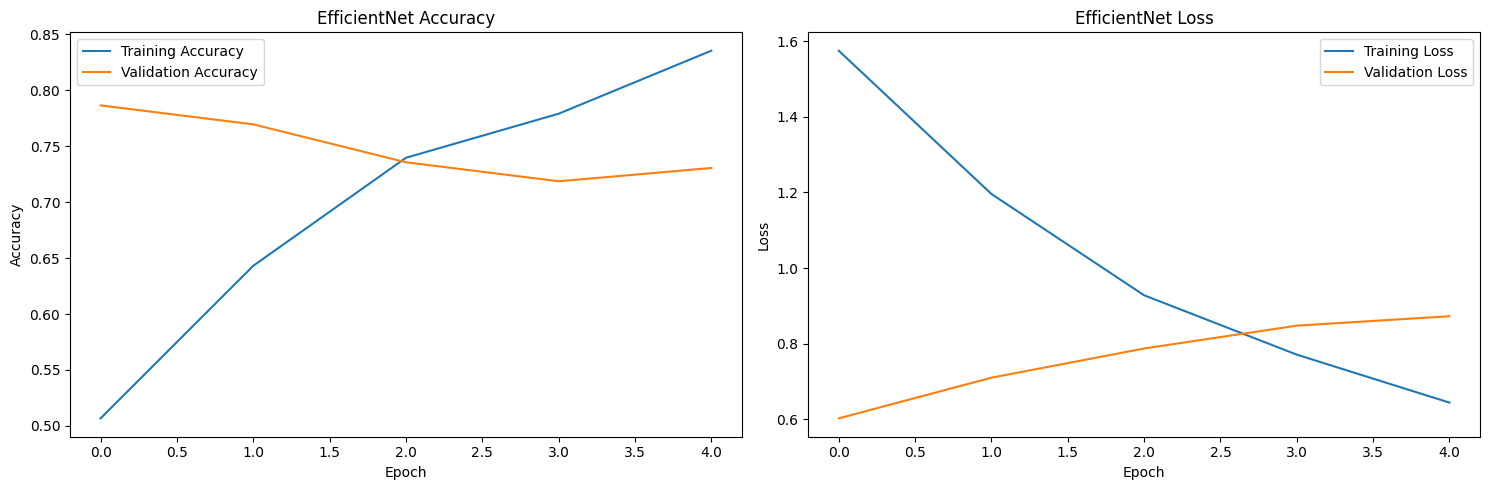

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step

Classification Report for EfficientNet:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.71      0.92      0.80        37
                     Pepper__bell___healthy       0.82      0.93   

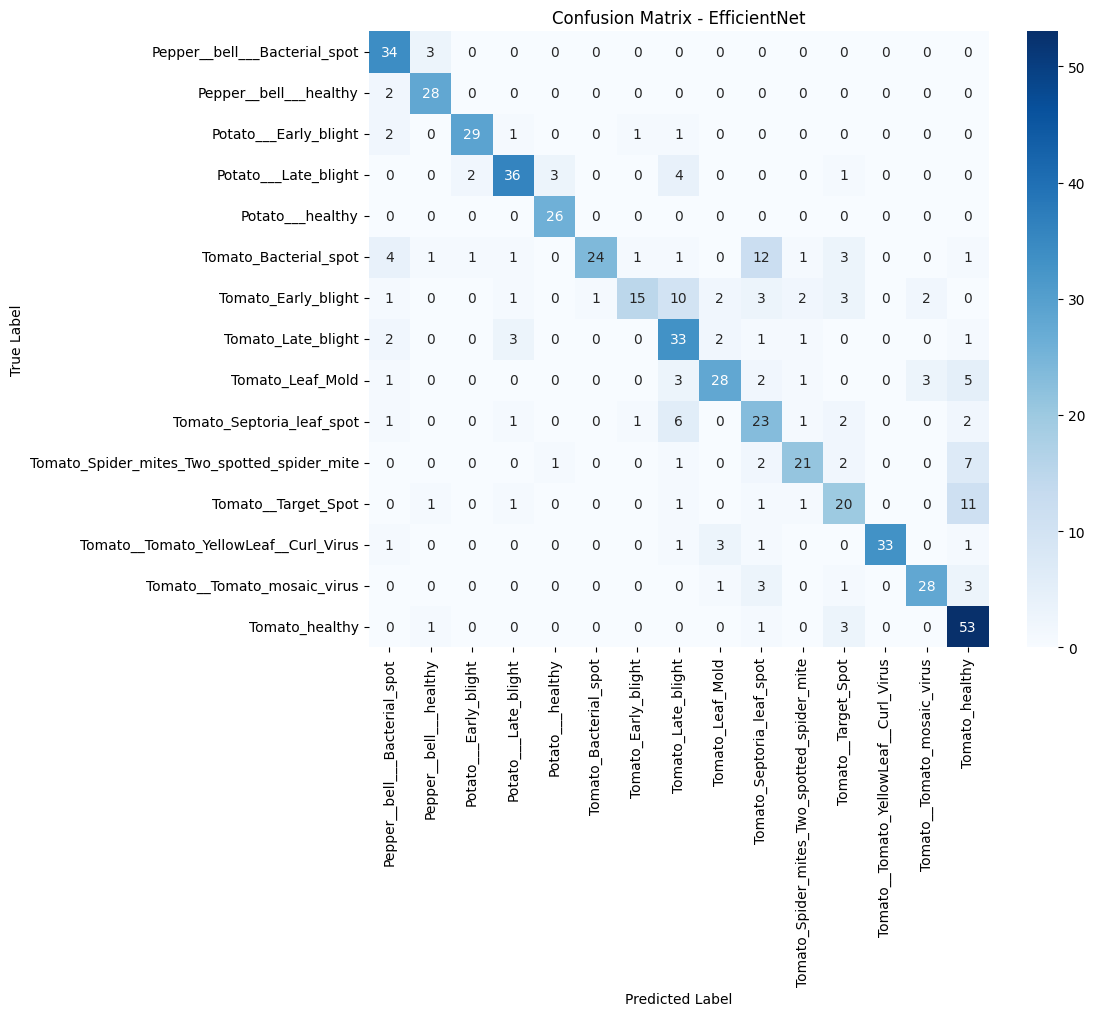

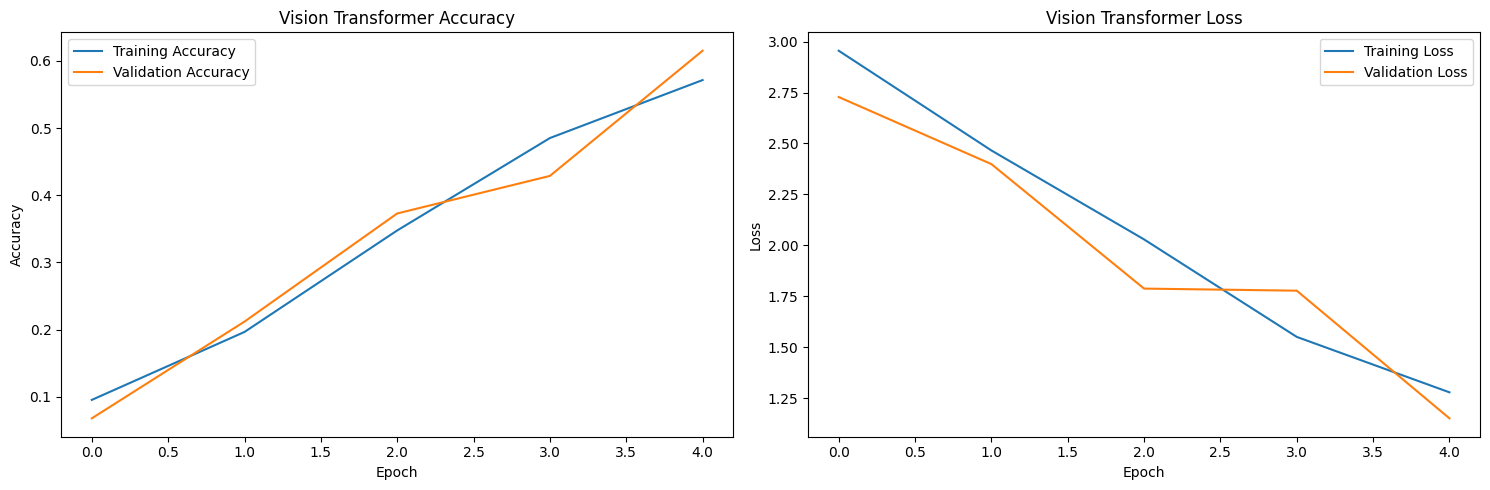

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━

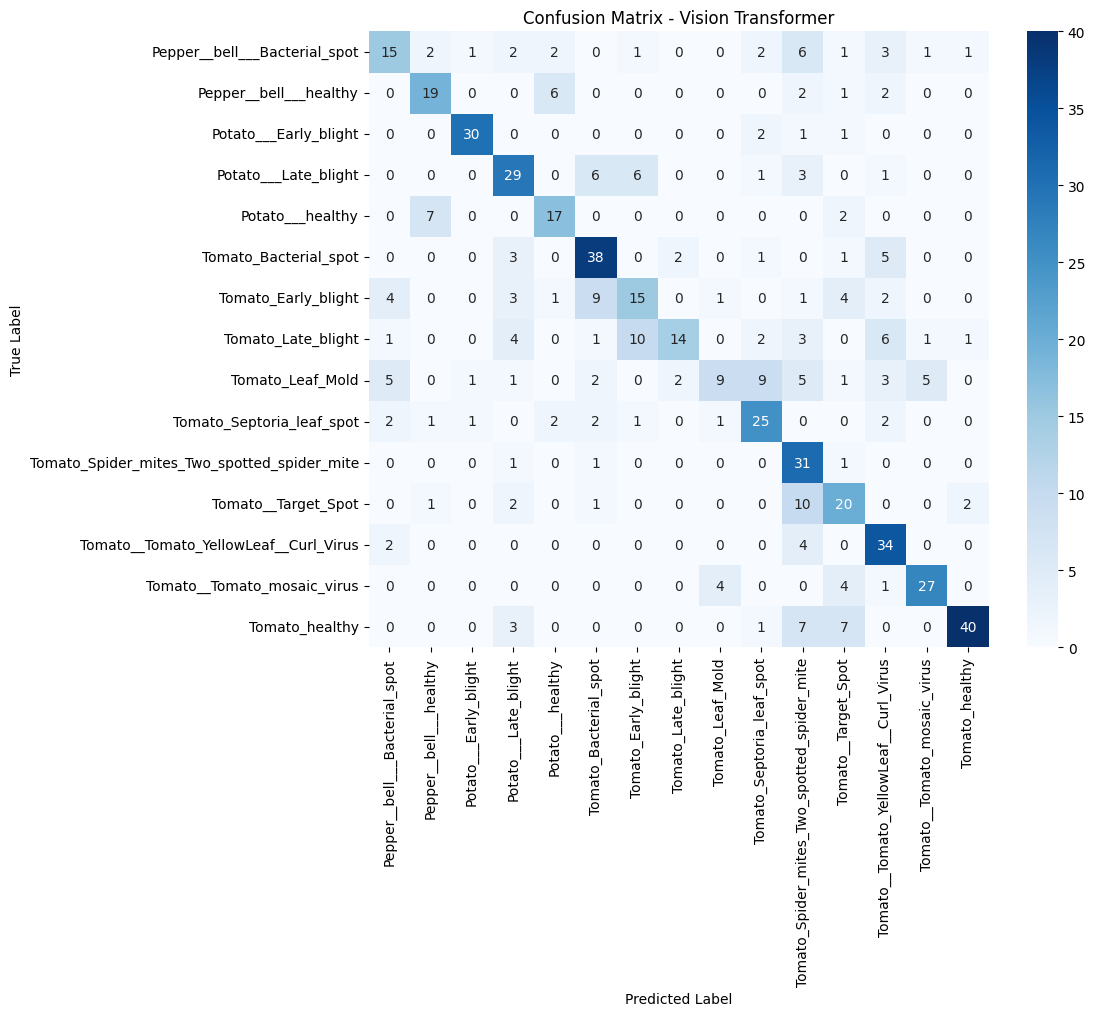

In [ ]:
# Evaluate EfficientNet
plot_training_history(history_effnet_fine, 'EfficientNet')
evaluate_model(model_effnet, val_ds_EFFNET, class_names, 'EfficientNet')

# Evaluate ViT
plot_training_history(history_head, 'Vision Transformer')
evaluate_model(vit_model, val_ds_VIT, class_names, 'Vision Transformer')